In [1]:
import pandas as pd
import numpy as np
import duckdb
from sqlalchemy import create_engine
import matplotlib.pyplot as plt
import seaborn as sns
from pygam import s, te, f, LinearGAM
import matplotlib.ticker as mtick

plt.style.use('ggplot')
cmap = sns.diverging_palette(220, 20, as_cmap=True)

In [3]:
pps_by_year = pd.read_sql("""WITH shots AS (
	SELECT *
		,CASE WHEN "EVENT_TYPE" = 'Made Shot' THEN 1 ELSE 0 END made_shot
	FROM public.shotdetail_raw
)
SELECT season + 1 season
	,AVG(CASE WHEN "SHOT_TYPE" = '2PT Field Goal' THEN made_shot END) * 2 two_pt_pps
	,AVG(CASE WHEN "SHOT_TYPE" = '2PT Field Goal' THEN "SHOT_DISTANCE" END) avg_two_pt_distance
	,AVG(CASE 
			WHEN "SHOT_TYPE" = '2PT Field Goal' 
				AND "SHOT_ZONE_BASIC" IN ('Restricted Area', 'In The Paint (Non-RA)') THEN 1
			WHEN "SHOT_TYPE" = '2PT Field Goal' THEN 0
		END) two_pt_paint_freq
	,AVG(CASE WHEN "SHOT_TYPE" = '3PT Field Goal' THEN made_shot END) * 3 three_pt_pps
	,AVG(CASE WHEN "SHOT_TYPE" = '3PT Field Goal' THEN "SHOT_DISTANCE" END) avg_three_pt_distance
    ,AVG(CASE 
			WHEN "SHOT_TYPE" = '3PT Field Goal' 
				AND "SHOT_ZONE_BASIC" IN ('Left Corner 3', 'Right Corner 3') THEN 1
			WHEN "SHOT_TYPE" = '3PT Field Goal' THEN 0
		END) three_pt_corner_freq
	
	,AVG(CASE WHEN "SHOT_ZONE_BASIC" IN ('In The Paint (Non-RA)', 'Restricted Area') THEN 1 ELSE 0 END) paint_freq
	,AVG(CASE WHEN "SHOT_ZONE_BASIC" IN ('Mid-Range') THEN 1 ELSE 0 END) midrange_freq
	,AVG(CASE WHEN "SHOT_ZONE_BASIC" IN ('Left Corner 3', 'Right Corner 3') THEN 1 ELSE 0 END) corner_three_freq
	,AVG(CASE WHEN "SHOT_ZONE_BASIC" IN ('Above the Break 3') THEN 1 ELSE 0 END) above_the_break_freq

	,AVG(CASE WHEN "SHOT_ZONE_BASIC" IN ('In The Paint (Non-RA)', 'Restricted Area') THEN made_shot END) * 2 paint_pps
	,AVG(CASE WHEN "SHOT_ZONE_BASIC" IN ('Mid-Range') THEN made_shot END) * 2 midrange_pps
	,AVG(CASE WHEN "SHOT_ZONE_BASIC" IN ('Left Corner 3', 'Right Corner 3') THEN made_shot END) * 3 corner_three_pps
	,AVG(CASE WHEN "SHOT_ZONE_BASIC" IN ('Above the Break 3') THEN made_shot END) * 3 above_the_break_three_pps
FROM shots
WHERE LEFT(CAST("GAME_ID" AS TEXT), 1) = '2'
	AND shots.season >= 1997
GROUP BY season""", engine)

In [4]:
pps_by_year['two_pt_midrange_freq'] = 1 - pps_by_year['two_pt_paint_freq']
pps_by_year['three_pt_above_break_freq'] = 1 - pps_by_year['three_pt_corner_freq']

In [5]:
pps_by_year;

In [6]:
def create_scatteplot_w_spline(data, x, y, label=None, linear=True, ax=None):
    X = data[x]
    y = data[y]
    
    spline = LinearGAM(s(0)).fit(X, y)
    predictions = spline.predict(X)
    
    sns.scatterplot(data=data, x=x, y=y, ax=ax)
    
    if ax == None:
        return plt.plot(X, predictions, label=label)
    else:
        ax.plot(X, predictions, label=label)
    

The large efficiency gap between 2-pointers and 3-pointers was by far the biggest point of emphasis in the early years of the analytics revolution. But in the past few years, that gap has basically shrunk to 0. In 2024, 3-pointers yielded only .007 points per possession (PPS) more than 2-pointers. And in the two years before that, 2-pointers were actually slightly more efficient. This is a huge contrast to the late 90's and early 00's. 3-pointers were more than .1 PPS more valuable than 2-pointers every year from 1999 to 2009.

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


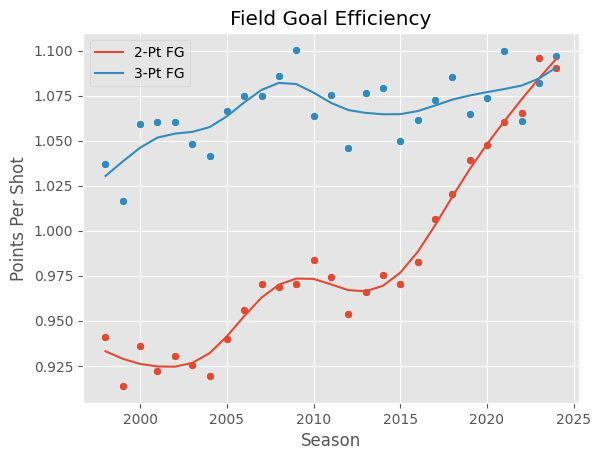

In [7]:
two_pt = create_scatteplot_w_spline(pps_by_year, 'season', 'two_pt_pps', label='2-Pt FG')
three_pt = create_scatteplot_w_spline(pps_by_year, 'season', 'three_pt_pps', label='3-Pt FG')
plt.legend(loc="upper left")
plt.xlabel("Season")
plt.ylabel("Points Per Shot")
plt.title("Field Goal Efficiency");

In [8]:
yearly_diff = pps_by_year.set_index('season')[['two_pt_pps', 'three_pt_pps']]
yearly_diff['Difference'] = yearly_diff['three_pt_pps'] - yearly_diff['two_pt_pps']

yearly_diff.index.name = ''

yearly_diff.rename({'two_pt_pps': 'PPS on 2-Pointers',
                   'three_pt_pps': 'PPS on 3-Pointers'}, axis=1).style\
            .background_gradient(subset=['Difference'],
                                   cmap=cmap,
                                   vmin=-yearly_diff['Difference'].max())\
        .format({'PPS on 2-Pointers': '{:.3f}',
                'PPS on 3-Pointers': '{:.3f}',
                'Difference': '{:.3f}'})

,PPS on 2-Pointers,PPS on 3-Pointers,Difference
,,,
1998,0.941,1.037,0.096
1999,0.914,1.016,0.102
2000,0.936,1.059,0.123
2001,0.922,1.061,0.138
2002,0.931,1.061,0.130
2003,0.925,1.048,0.123
2004,0.919,1.042,0.122
2005,0.940,1.067,0.127
2006,0.956,1.075,0.119


The biggest reason for this shrinking difference has been the fact that teams are taking much easier 2-pointers and slightly more difficult 3-pointers, as measured by average distance.

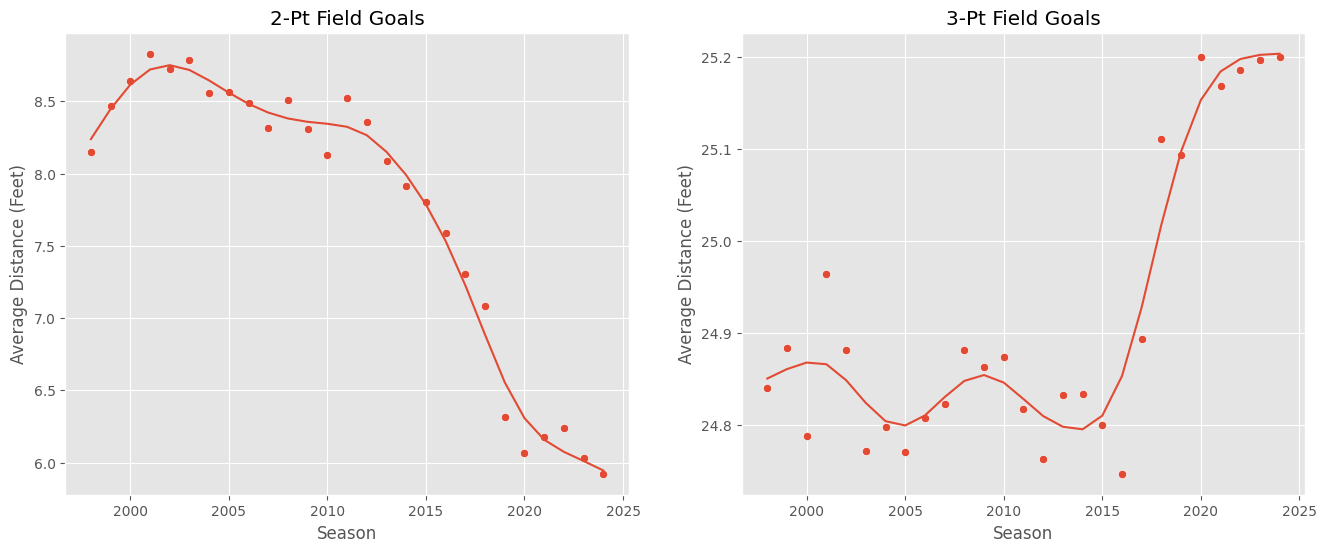

In [9]:
fig, axs = plt.subplots(1, 2, figsize=(16, 6));

two_pt = create_scatteplot_w_spline(pps_by_year, 'season', 'avg_two_pt_distance', label='2-Pt FG', ax=axs[0])
axs[0].set_xlabel("Season")
axs[0].set_ylabel("Average Distance (Feet)")
axs[0].set_title("2-Pt Field Goals");

three_pt = create_scatteplot_w_spline(pps_by_year, 'season', 'avg_three_pt_distance', label='3-Pt FG', ax=axs[1])
axs[1].set_xlabel("Season")
axs[1].set_ylabel("Average Distance (Feet)")
axs[1].set_title("3-Pt Field Goals");

The drop in the average distance of 2-pointers has mainly been driven by the abandonment of the midrange jumper.

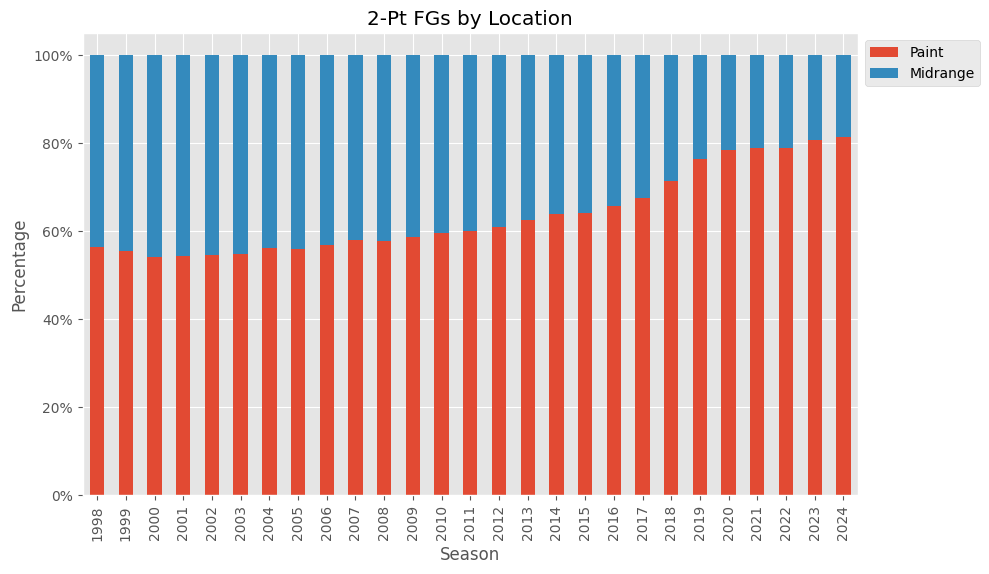

In [16]:
fig, axs = plt.subplots(1, 1, figsize=(10, 6));

pps_by_year.set_index('season')[['two_pt_paint_freq', 'two_pt_midrange_freq']].plot.bar(stacked=True, ax=axs)
axs.set_title('2-Pt FGs by Location')
axs.set_xlabel('Season')
axs.set_ylabel('Percentage')
axs.yaxis.set_major_formatter(mtick.PercentFormatter(1.0))
axs.legend(labels=['Paint', 'Midrange'], bbox_to_anchor=(1, 1));
"""
pps_by_year.set_index('season')[['two_pt_paint_freq', 'two_pt_midrange_freq']].plot.bar(stacked=True, ax=axs[0])
axs[0].set_title('2-Pt FGs by Location')
axs[0].set_xlabel('Season')
axs[0].set_ylabel('Percentage')
axs[0].yaxis.set_major_formatter(mtick.PercentFormatter(1.0))
axs[0].legend(labels=['Paint', 'Midrange']);""";

So we know that the composition of shot types has changed over the years. But how has the efficiency of these shot types changed? Some have speculated that as defenses shift their focus to defending the paint and the 3-point line, midrange shots may eventually close the efficiency gap.

Well so far, that hasn't happened. While shots from all areas have seen an uptick in efficiency, the midrange area remains by far the least efficient location to shoot from. The painted area has seen the biggest increase in efficiency in the past 26 years, possibly because of better spacing.

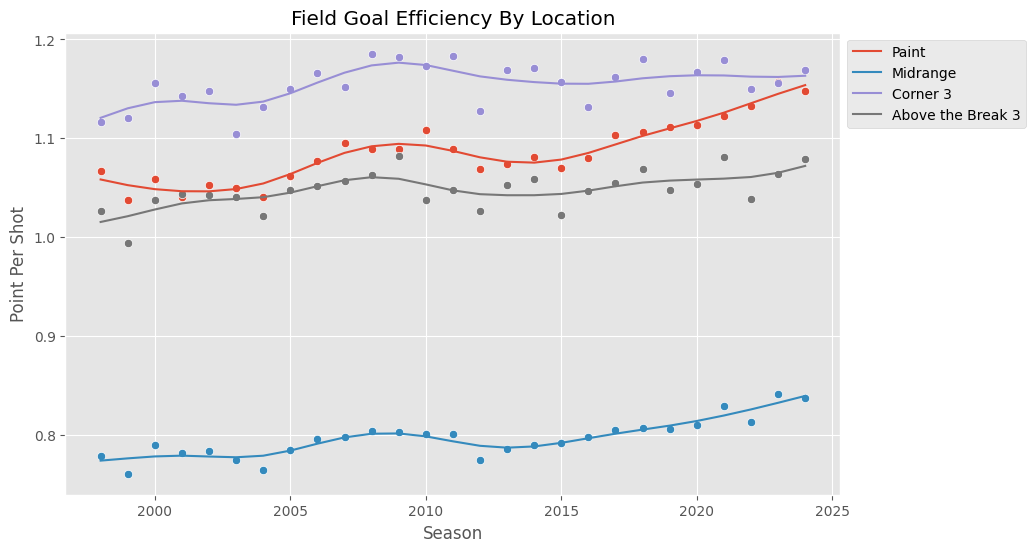

In [18]:
fig, ax = plt.subplots(1, 1, figsize=(10, 6));

paint = create_scatteplot_w_spline(pps_by_year, 'season', 'paint_pps', label='Paint', ax=ax)
midrange = create_scatteplot_w_spline(pps_by_year, 'season', 'midrange_pps', label='Midrange', ax=ax)
corner = create_scatteplot_w_spline(pps_by_year, 'season', 'corner_three_pps', label='Corner 3', ax=ax)
above_break = create_scatteplot_w_spline(pps_by_year, 'season', 'above_the_break_three_pps',
                                         label='Above the Break 3', ax=ax)

ax.legend(bbox_to_anchor=(1, 1.))
plt.ylabel('Point Per Shot')
plt.xlabel('Season')
plt.title('Field Goal Efficiency By Location');

In [12]:
first_season = pps_by_year[pps_by_year['season'] == 1998]\
    [['paint_pps', 'midrange_pps', 'corner_three_pps', 'above_the_break_three_pps']].T
first_season.columns = ['97-98 Season']

last_season = pps_by_year[pps_by_year['season'] == 2024]\
    [['paint_pps', 'midrange_pps', 'corner_three_pps', 'above_the_break_three_pps']].T
last_season.columns = ['23-24 Season']


merged_df = first_season.merge(last_season, how='inner', left_index=True, right_index=True)
merged_df['Difference'] = merged_df['23-24 Season'] - merged_df['97-98 Season']
merged_df.rename({'paint_pps': 'Paint PPS',
                 'midrange_pps': 'Midrange PPS',
                 'corner_three_pps': 'Corner 3 PPS',
                 'above_the_break_three_pps': 'Above the Break 3 PPS'})\
        .style.background_gradient(subset=['Difference'],
                                   cmap=cmap,
                                   vmin=0)\
        .format({'97-98 Season': '{:.2f}',
                '23-24 Season': '{:.2f}',
                'Difference': '{:.3f}'})

,97-98 Season,23-24 Season,Difference
Paint PPS,1.07,1.15,0.082
Midrange PPS,0.78,0.84,0.059
Corner 3 PPS,1.12,1.17,0.053
Above the Break 3 PPS,1.03,1.08,0.053


So is the 3-point premium dead? Sort of. The average 2-pointer has shrunk the gap, but it's valuable to look at the nuances of where exactly those shots are coming from. The choice that many teams and players have made is to trade midrange jumpers for 3-pointers, not layups for 3-pointers. From that perspective, the 3-point premium is alive and well, as midrange shots remain very inefficient.